In [1]:
import sys
sys.path.append('../') 

In [2]:

%load_ext autoreload
%autoreload 2
import sklearn
import copy
import numpy as np

import seaborn as sns
sns.set()

import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# from viz import viz
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
from sklearn.model_selection import RandomizedSearchCV
import load_data


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from fit_and_predict import fit_and_predict
from shared_models import SharedModel
from collections import defaultdict 



## Params:

In [3]:
aggregate_by_state = False
outcome_type = 'deaths'

## Basic Data Visualization

In [4]:
# Just something to quickly summarize the number of cases and distributions each day

In [5]:
# 'deaths' and 'cases' contain the time-series of the outbreak
df = load_data.load_county_level(data_dir = '../data/')
df = df.sort_values('#Deaths_3/30/2020', ascending=False)
# outcome_cases = load_data.outcome_cases # most recent day
# outcome_deaths = load_data.outcome_deaths
important_vars = load_data.important_keys(df)
very_important_vars = ['PopulationDensityperSqMile2010',
#                        'MedicareEnrollment,AgedTot2017',
                       'Respiratory Mortality',
                       'PopulationEstimate2018',
                       '#ICU_beds',
                       'MedianAge2010',
                       'Smokers_Percentage',
                       'DiabetesPercentage',
                       'HeartDiseaseMortality',
                        '#Hospitals'
#                        'PopMale60-642010',
#                         'PopFmle60-642010',
#                          'PopMale65-742010',
#                          'PopFmle65-742010',
#                          'PopMale75-842010',
#                          'PopFmle75-842010',
#                          'PopMale>842010',
#                          'PopFmle>842010'
                      ]

In [151]:
neighboring_counties_df = pd.read_csv('../data_new/county_level/raw/county_ids/county_adjacency2010.csv')

In [141]:
for c in df.columns:
    if 'County' in c or 'county' in c:
        print(c)

CountyName
CountyNamew/StateAbbrev
FIPSCountyCode
CBSACountyStatusCentralorOutlying2018
HPSACode-PrimaryCare05/191=Whole,2=PartCounty2019
HPSACode-PrimaryCare05/181=Whole,2=PartCounty2018
HPSACode-PrimaryCare05/171=Whole,2=PartCounty2017
HPSACode-PrimaryCare05/161=Whole,2=PartCounty2016
HPSACode-PrimaryCare06/151=Whole,2=PartCounty2015
HPSACode-PrimaryCare12/101=Whole,2=PartCounty2010
HPSACode-Dentists05/191=Whole,2=PartCounty2019
HPSACode-Dentists05/181=Whole,2=PartCounty2018
HPSACode-Dentists05/171=Whole,2=PartCounty2017
HPSACode-Dentists05/161=Whole,2=PartCounty2016
HPSACode-Dentists06/151=Whole,2=PartCounty2015
HPSACode-Dentists12/101=Whole,2=PartCounty2010
HPSACode-MentalHealth05/191=Whole,2=PartCounty2019
HPSACode-MentalHealth05/181=Whole,2=PartCounty2018
HPSACode-MentalHealth05/171=Whole,2=PartCounty2017
HPSACode-MentalHealth05/161=Whole,2=PartCounty2016
HPSACode-MentalHealth06/151=Whole,2=PartCounty2015
HPSACode-MentalHealth12/101=Whole,2=PartCounty2010
ContiguousCounty#1
Conti

In [142]:
df['CountyNamew/StateAbbrev']


1824       Kings, NY
1841      Queens, NY
1803       Bronx, NY
1831    New York, NY
1830      Nassau, NY
            ...     
2654       Mason, TX
2624     Kendall, TX
1915         Lee, NC
2375     Lincoln, SD
3047      Juneau, WI
Name: CountyNamew/StateAbbrev, Length: 2503, dtype: object

In [152]:
neighboring_counties['countyname'] = [n.split(',')[0] for ] 


SyntaxError: invalid syntax (<ipython-input-152-e29904681e05>, line 1)

In [198]:
for i,c in enumerate(list(neighboring_counties_df['countyname'])):
    if 'Orleans' in c:
        print(neighboring_counties_df.iloc[i])

countyname        Orleans Parish, LA
fipscounty                     22071
neighborname    Jefferson Parish, LA
fipsneighbor                   22051
Name: 7944, dtype: object
countyname      Orleans Parish, LA
fipscounty                   22071
neighborname    Orleans Parish, LA
fipsneighbor                 22071
Name: 7945, dtype: object
countyname          Orleans Parish, LA
fipscounty                       22071
neighborname    Plaquemines Parish, LA
fipsneighbor                     22075
Name: 7946, dtype: object
countyname          Orleans Parish, LA
fipscounty                       22071
neighborname    St. Bernard Parish, LA
fipsneighbor                     22087
Name: 7947, dtype: object
countyname          Orleans Parish, LA
fipscounty                       22071
neighborname    St. Tammany Parish, LA
fipsneighbor                     22103
Name: 7948, dtype: object
countyname      Orleans County, NY
fipscounty                   36073
neighborname    Genesee County, NY
fipsneigh

In [199]:
neighboring_counties_df['countyname_clean'] = [n.split()[0] + ', '+ n.split()[-1] for n in list(neighboring_counties_df['countyname'])]
neighboring_counties_df['neighborname_clean'] = [n.split()[0] + ', '+ n.split()[-1] for n in list(neighboring_counties_df['neighborname'])]

In [206]:
df['countyFIPS']


1824    36047
1841    36081
1803    36005
1831    36061
1830    36059
        ...  
2654    48319
2624    48259
1915    37105
2375    46083
3047    55057
Name: countyFIPS, Length: 2503, dtype: int64

In [204]:
for c in df.columns:
    if 'FIPS' in c:
        print(c)

Header-FIPSStandCtyCode
FIPSStateCode
FIPSCountyCode
countyFIPS


In [200]:
neighboring_counties_df


,countyname,fipscounty,neighborname,fipsneighbor,countyname_clean,neighborname_clean
0,"Autauga County, AL",1001,"Autauga County, AL",1001,"Autauga, AL","Autauga, AL"
1,"Autauga County, AL",1001,"Chilton County, AL",1021,"Autauga, AL","Chilton, AL"
2,"Autauga County, AL",1001,"Dallas County, AL",1047,"Autauga, AL","Dallas, AL"
3,"Autauga County, AL",1001,"Elmore County, AL",1051,"Autauga, AL","Elmore, AL"
4,"Autauga County, AL",1001,"Lowndes County, AL",1085,"Autauga, AL","Lowndes, AL"
...,...,...,...,...,...,...
22195,"St. Croix Island, VI",78010,"St. Croix Island, VI",78010,"St., VI","St., VI"
22196,"St. John Island, VI",78020,"St. John Island, VI",78020,"St., VI","St., VI"
22197,"St. John Island, VI",78020,"St. Thomas Island, VI",78030,"St., VI","St., VI"
22198,"St. Thomas Island, VI",78030,"St. John Island, VI",78020,"St., VI","St., VI"


In [472]:
county_neighbor_deaths = []
county_neighbor_cases = []
county_fips = list(df['countyFIPS'])
for fips in county_fips:


    neighboring_counties = list(neighboring_counties_df.loc[neighboring_counties_df['fipscounty'] == fips ]['fipsneighbor'])
    neighboring_county_deaths = list(df.loc[df['countyFIPS'].isin(neighboring_counties)]['deaths'])
    neighboring_county_cases = list(df.loc[df['countyFIPS'].isin(neighboring_counties)]['cases'])
    
    sum_neighboring_county_deaths = np.zeros(len(neighboring_county_deaths[0]))
    for deaths in neighboring_county_deaths:
        sum_neighboring_county_deaths += deaths
    sum_neighboring_county_cases = np.zeros(len(neighboring_county_deaths[0]))
    for cases in neighboring_county_cases:
        sum_neighboring_county_cases += cases
    county_neighbor_deaths.append(sum_neighboring_county_deaths)
    county_neighbor_cases.append(sum_neighboring_county_cases)


        


    
    
    




In [473]:
df['neighbor_deaths'] = county_neighbor_deaths
df['neighbor_cases'] = county_neighbor_cases


In [474]:
def sum_lists(list_of_lists):
    arr = np.array(list(list_of_lists))
    sum_arr = np.sum(arr,0)
    return list(sum_arr)
if aggregate_by_state:
    # Aggregate by State
    state_deaths_df = df.groupby('StateNameAbbreviation').deaths.agg(sum_lists).to_frame()
    state_cases_df = df.groupby('StateNameAbbreviation').cases.agg(sum_lists).to_frame()
    df =  pd.concat([state_cases_df,state_deaths_df],axis =1 )

Number of counties with non-zero cases
2503


(array([168.,  95.,  69.,  55.,  34.,  35.,  26.,  24.,  18.,  20.,  17.,
         12.,  11.,  11.,  15.,   8.,   7.,   6.,  10.,   8.,   7.,   4.,
          6.,   5.,   5.,   6.,   4.,   3.,   2.,   8.,   2.,   2.,   5.,
          1.,   2.,   6.,   2.,   2.,   2.,   3.,   3.,   1.,   2.,   1.,
          2.,   1.,   0.,   0.,   2.,   0.,   1.,   2.,   2.,   2.,   1.,
          2.,   1.,   1.,   2.,   0.,   2.,   1.,   1.,   2.,   1.,   0.,
          1.,   0.,   2.,   2.,   0.,   2.,   1.,   1.,   0.,   1.,   2.,
          1.,   0.,   1.,   2.,   0.,   0.,   3.,   0.,   0.,   0.,   1.,
          2.,   2.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   1.,   1.,
          1.]),
 array([ 21.  ,  30.76,  40.52,  50.28,  60.04,  69.8 ,  79.56,  89.32,
         99.08, 108.84, 118.6 , 128.36, 138.12, 147.88, 157.64, 167.4 ,
        177.16, 186.92, 196.68, 206.44, 216.2 , 225.96, 235.72, 245.48,
        255.24, 265.  , 274.76, 284.52, 294.28, 304.04, 313.8 , 323.56,
        333.32, 343.08, 352.84

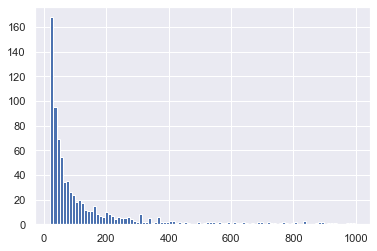

In [475]:
# Distribution of the maximum number of cases
_cases = list(df['cases'])

max_cases = []
for i in range(len(df)):
    max_cases.append(max(_cases[i]))

print('Number of counties with non-zero cases')
print(sum([v >0 for v in max_cases]))


# cases truncated below 20 and above 1000 for plot readability
plt.hist([v for v in max_cases if v > 20 and v < 1000],bins = 100)


In [476]:
sum(max_cases)

389718

In [477]:
print(sum([v > 50 for v in max_cases]))


516


In [478]:
np.quantile(max_cases,.5)

9.0

Number of counties with non-zero deaths
833


(array([189.,  16.,   6.,   3.,   3.,   3.,   3.,   1.,   0.,   0.,   1.,
          0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([   6.        ,   44.23333333,   82.46666667,  120.7       ,
         158.93333333,  197.16666667,  235.4       ,  273.63333333,
         311.86666667,  350.1       ,  388.33333333,  426.56666667,
         464.8       ,  503.03333333,  541.26666667,  579.5       ,
         617.73333333,  655.96666667,  694.2       ,  732.43333333,
         770.66666667,  808.9       ,  847.13333333,  885.36666667,
         923.6       ,  961.83333333, 1000.06666667, 1038.3       ,
        1076.53333333, 1114.76666667, 1153.        ]),
 <a list of 30 Patch objects>)

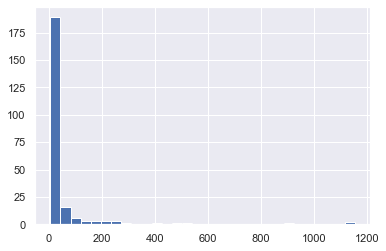

In [479]:
# Distribution of the maximum number of cases
_deaths = list(df['deaths'])

max_deaths = []
for i in range(len(df)):
    max_deaths.append(max(_deaths[i]))

    
print('Number of counties with non-zero deaths')
print(sum([v > 0 for v in max_deaths]))
# plt.hist(max_cases)

# print(sum([v >0 for v in max_cases]))
plt.hist([v for v in max_deaths if v > 5],bins=30)

In [480]:
sum(max_deaths)

12403

In [481]:
max(max_deaths)

1153

In [482]:
np.quantile(max_deaths,.7)

1.0

### Clean data

In [483]:
# Remove counties with zero cases
max_cases = [max(v) for v in df['cases']]
df['max_cases'] = max_cases
max_deaths = [max(v) for v in df['deaths']]
df['max_deaths'] = max_deaths
df =  df[df['max_cases'] > 0]



## Predict data from model:

In [484]:
method_keys = []

In [485]:
# clear predictions
for m in method_keys:
    del df[m]
    

In [486]:
# target_day = np.array([1])
# # Trains model on train_df and produces predictions for the final day for test_df and writes prediction
# # to a new column for test_df 
# # fit_and_predict(df, method='exponential', outcome=outcome_type, mode='eval_mode',target_day=target_day)
# # fit_and_predict(df,method='shared_exponential', outcome=outcome_type, mode='eval_mode',target_day=target_day)
# # fit_and_predict(train_df, test_df,'shared_exponential', mode='eval_mode',demographic_vars=important_vars)
# # fit_and_predict(df,method='shared_exponential', outcome=outcome_type, mode='eval_mode',demographic_vars=very_important_vars,target_day=target_day)
# fit_and_predict(df, outcome=outcome_type, mode='eval_mode',demographic_vars=[],
#                                      method='ensemble',target_day=target_day)
# fit_and_predict(df, outcome=outcome_type, mode='eval_mode',demographic_vars=[],
#                                      method='ensemble',target_day=np.array([1,2,3]))
# # fit_and_predict(train_df, test_d f,method='exponential',mode='eval_mode',target_day = np.array([1,2]))

# # Finds the names of all the methods
# method_keys = [c for c in df if 'predicted' in c]
# method_keys

In [487]:
# for days_ahead in [1, 2, 3]:
#      for method in ['exponential', 'shared_exponential', 'ensemble']:  
#         fit_and_predict(df, method=method, outcome=outcome_type, mode='eval_mode',target_day=np.array([days_ahead]))
        
#         if method == 'shared_exponential':
#             fit_and_predict(df,method='shared_exponential', 
#                             outcome=outcome_type, 
#                              mode='eval_mode',
#                              demographic_vars=very_important_vars,
#                              target_day=np.array([days_ahead]))
# method_keys = [c for c in df if 'predicted' in c]
# geo = ['countyFIPS', 'CountyNamew/StateAbbrev']

In [488]:
# method_keys = [c for c in df if 'predicted' in c]
# df_preds = df[method_keys + geo + ['deaths']]
# df_preds.to_pickle("multi_day_6.pkl")

## Ensemble predictions

In [658]:
exponential = {'model_type':'exponential'}
shared_exponential = {'model_type':'shared_exponential'}
demographics = {'model_type':'shared_exponential', 'demographic_vars':very_important_vars}
linear = {'model_type':'linear'}

In [659]:
# import fit_and_predict
# for d in [1, 2, 3]:
#     df = fit_and_predict.fit_and_predict_ensemble(df, 
#                                                   target_day=np.array([d]),
#                                                   mode='eval_mode',
#                                                   outcome=outcome_type,
#                                                   output_key=f'predicted_{outcome_type}_ensemble_{d}'
#                                                    )

In [765]:
feat_transforms = defaultdict(lambda y: [lambda x: x]) 
# feat_transforms['deaths'] = [lambda x: np.log(x+1),lambda x: np.log(np.log(x+1)+1)]
# feat_transforms['cases'] =  [lambda x: np.log(x+1),lambda x: np.log(np.log(x+1)+1)]
# feat_transforms['neighbor_deaths'] =  [lambda x: np.log(x+1),lambda x: np.log(np.log(x+1)+1)]
# feat_transforms['neighbor_cases'] = [lambda x: np.log(x+1),lambda x: np.log(np.log(x+1)+1)]

feat_transforms['deaths'] = [lambda x: np.log(x+1)]
feat_transforms['cases'] =  [lambda x: np.log(x+1)]
feat_transforms['neighbor_deaths'] =  [lambda x: np.log(x+1)]
feat_transforms['neighbor_cases'] =  [lambda x: np.log(x+1)]
default_values = defaultdict(lambda: 0) 

In [766]:

feat_transforms['neighbor_deaths']

[<function __main__.<lambda>(x)>]

In [767]:
shared_model = SharedModel(df=df,outcome=outcome_type,demographic_variables=[],mode='eval_mode',target_days=np.array(range(1,10)),
                           feat_transforms=feat_transforms,auxiliary_time_features=['cases','neighbor_deaths','neighbor_cases'],time_series_default_values=default_values,scale=True)
# shared_model = SharedModel(df=df,outcome=outcome_type,demographic_variables=[],mode='eval_mode',target_days=np.array(range(1,8)),
#                            feat_transforms=feat_transforms,auxiliary_time_features=['cases'],time_series_default_values=default_values,scale=True)

shared_model = SharedModel(df=df,outcome=outcome_type,demographic_variables=[],mode='eval_mode',target_days=np.array(range(1,10)),
                           feat_transforms=feat_transforms,auxiliary_time_features=['neighbor_deaths'],time_series_default_values=default_values,scale=True)


In [768]:
shared_model.create_dataset()

In [769]:
shared_model.fit_model()


In [770]:
shared_model.predict()

In [771]:
shared_model.model.params

array([ 0.96585226, -0.04113699,  1.94894313])

In [772]:
import fit_and_predict

df = fit_and_predict.fit_and_predict_ensemble(df, 
                                              target_day=np.array(range(1,10)),
                                              mode='eval_mode',
                                              outcome=outcome_type,
                                              methods=[ 
#                                                       exponential, 
                                                       shared_exponential,
#                                                       demographics,

#                                                           linear
                                                     ],
                                              output_key=f'predicted_{outcome_type}_ensemble_3_with_exponential'
                                               ) 

Feature weights
log(deaths) : 1.0248913712359662
bias : 0.029696343616870714


Feature weights
log(deaths) : 0.9904022019843026
bias : 0.0933393048135703


Feature weights
log(deaths) : 0.9686695896406214
bias : 0.12676398500281752


Feature weights
log(deaths) : 0.9511551353481537
bias : 0.14471705795742987


Feature weights
log(deaths) : 0.9228869019174359
bias : 0.17639672120576702


Feature weights
log(deaths) : 0.8976635426072654
bias : 0.19898982018518452


Feature weights
log(deaths) : 1.007510314776908
bias : 0.023605360758676995


Feature weights
log(deaths) : 1.0052458021169721
bias : 0.026780238030961218


--- Model Contributions ---
{'model_type': 'shared_exponential'}: 1.0


In [746]:
# import fit_and_predict
# for d in [4]:
#     df = fit_and_predict.fit_and_predict_ensemble(df, 
#                                                   target_day=np.array(range(1, d+1)),
#                                                   mode='eval_mode',
#                                                   outcome=outcome_type,
#                                                   methods=[ 
# #                                                       exponential, 
#                                                            shared_exponential,
# #                                                       demographics,

# #                                                           linear
#                                                          ],
#                                                   output_key=f'predicted_{outcome_type}_ensemble_{d}_with_exponential'
#                                                    ) 

In [747]:
# Feature weights
# PopulationDensityperSqMile2010 : 0.004745182621539039
# Respiratory Mortality : -0.05173444687184794
# PopulationEstimate2018 : -0.046866686419304526
# #ICU_beds : -0.011788640479631832
# MedianAge2010 : 0.03579904251021662
# Smokers_Percentage : 0.00824343481343873
# DiabetesPercentage : 0.01833651602597799
# HeartDiseaseMortality : 0.030078534240604964
# #Hospitals : 0.07194365950227814
# log(deaths) : 0.983469697152724
# bias : 1.0144103433866933

In [748]:
method_keys = [c for c in df if 'predicted' in c]

In [749]:
# df = fit_and_predict.fit_and_predict_ensemble(df)

In [750]:
method_keys

['predicted_deaths_ensemble_3_with_exponential',
 'predicted_deaths_ensemble_3_with_cases']

In [751]:
df['predicted_deaths_ensemble_3_with_cases'] = shared_model.predictions
method_keys.append('predicted_deaths_ensemble_3_with_cases')

## Evaluate and visualize models

### Compute MSE and log MSE on relevant cases

In [752]:


# TODO: add average rank as metric

In [753]:
# Computes the mse in log space and non-log space for all columns

In [754]:
def l1(arr1,arr2,norm=True):
    """
    arr2 ground truth
    arr1 predictions
    """
    if norm:
        sum_percent_dif = 0
        for i in range(len(arr1)):
            sum_percent_dif += np.abs(arr2[i]-arr1[i])/arr1[i]
        return sum_percent_dif/len(arr1)
            
    return sum([np.abs(a1-a2) for (a1,a2) in zip(arr1,arr2)])/len(arr1)
mse = sklearn.metrics.mean_squared_error
# Only evaluate points that exceed this number of deaths 
# lower_threshold, upper_threshold = 10, 100000
lower_threshold, upper_threshold = 10, np.inf

In [755]:

# Log scaled
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1] + 1) for p in df[key][(outcome > lower_threshold)]] # * (outcome < upper_threshold)]]
    print('Log scale MSE for '+key)
    print(mse(np.log(outcome[(outcome > lower_threshold) * (outcome < upper_threshold)] + 1),preds))

Log scale MSE for predicted_deaths_ensemble_3_with_exponential
0.3147493609913972
Log scale MSE for predicted_deaths_ensemble_3_with_cases
0.4737359476596679
Log scale MSE for predicted_deaths_ensemble_3_with_cases
0.4737359476596679


In [756]:
# Log scaled
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1] + 1) for p in df[key][outcome > lower_threshold]]
    print('Log scale l1 for '+key)
    print(l1(np.log(outcome[outcome > lower_threshold] + 1),preds))

Log scale l1 for predicted_deaths_ensemble_3_with_exponential
0.1468004888953975
Log scale l1 for predicted_deaths_ensemble_3_with_cases
0.14654425016810774
Log scale l1 for predicted_deaths_ensemble_3_with_cases
0.14654425016810774


In [757]:
#alpha = .01, 1600.2934499171229

In [758]:
# alpha = 0, 1542.4338963814796

In [759]:
# No log scale
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > lower_threshold]]
    print('Raw MSE for '+key)
    print(mse(outcome[outcome > lower_threshold],preds))

Raw MSE for predicted_deaths_ensemble_3_with_exponential
10577.876587974222
Raw MSE for predicted_deaths_ensemble_3_with_cases
19588.240217805633
Raw MSE for predicted_deaths_ensemble_3_with_cases
19588.240217805633


In [715]:
#[alpha = .01, 1122.4187100081517]
#[alpha = .001, 1103.7477272612207]
#[alpha = 0,1101.7658699463036]

In [716]:
# No log scale
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > lower_threshold]]
    print('Raw l1 for '+key)
    print(l1(outcome[outcome > lower_threshold],preds))

Raw l1 for predicted_deaths_ensemble_3_with_exponential
0.6356618659537056
Raw l1 for predicted_deaths_ensemble_3_with_cases
0.47769946026667254
Raw l1 for predicted_deaths_ensemble_3_with_cases
0.47769946026667254


In [717]:
# No log scale
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > lower_threshold]]
    print('Raw l1 for '+key)
    print(l1(outcome[outcome > lower_threshold],preds,norm=False))

Raw l1 for predicted_deaths_ensemble_3_with_exponential
37.33584496518355
Raw l1 for predicted_deaths_ensemble_3_with_cases
30.31445499124394
Raw l1 for predicted_deaths_ensemble_3_with_cases
30.31445499124394


### Plot residuals

In [685]:
# TODO: Create bounds automatically, create a plot function and call it instead of copying code, figure out way
# to plot more than two things at once cleanly

# Creates residual plots log scaled and raw
# We only look at cases with number of deaths greater than 5

In [686]:
def method_name_to_pretty_name(key):
    # TODO: hacky, fix
    words = key.split('_')
    words2 = []
    for w in words:
        if not w.isnumeric():
            words2.append(w)
        else:
            num = w
            
    model_name = ' '.join(words2[2:])
#     model_name = 'model'
    if num == '1':
        model_name += ' predicting 1 day ahead'
    else:
        model_name += ' predicting ' +w+' days ahead'
        
    return model_name

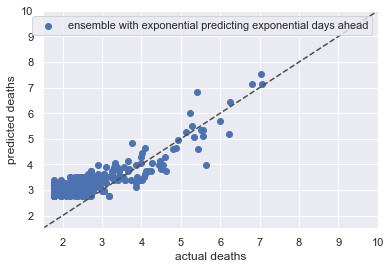

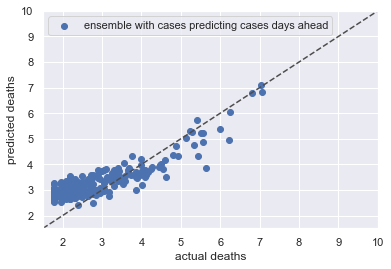

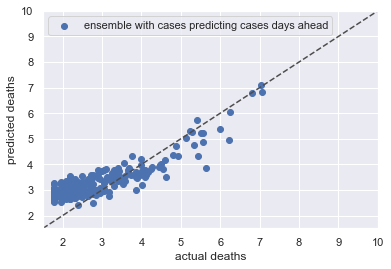

In [687]:
# Make log plots:
bounds = [1.5, 10]
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1]) for p in df[key][outcome > 5]]
    plt.scatter(np.log(outcome[outcome > 5]),preds,label=method_name_to_pretty_name(key))
    plt.xlabel('actual '+outcome_type)
    plt.ylabel('predicted '+outcome_type)
    plt.xlim(bounds)
    plt.ylim(bounds)
    plt.legend()

    plt.plot(bounds, bounds, ls="--", c=".3")
    plt.show()

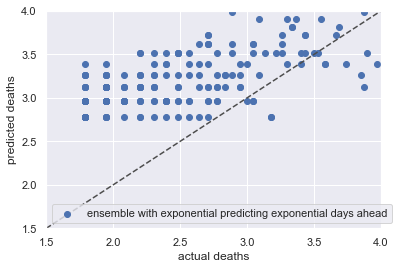

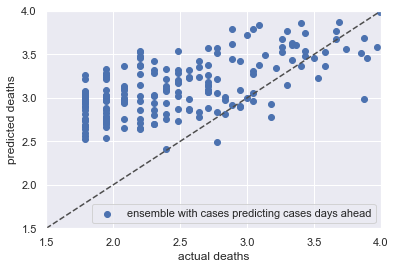

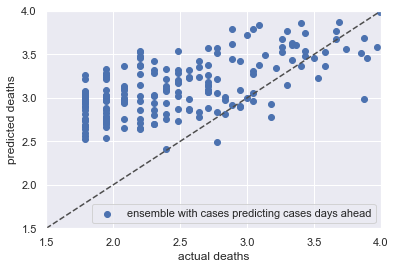

In [688]:
# Make log plots zoomed in for the counties that have a fewer number of deaths
bounds = [1.5, 4]
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1]) for p in df[key][outcome > 5]]
    plt.scatter(np.log(outcome[outcome > 5]),preds,label=method_name_to_pretty_name(key))

    plt.xlabel('actual '+outcome_type)
    plt.ylabel('predicted '+outcome_type)
    plt.xlim(bounds)
    plt.ylim(bounds)
    plt.legend()

    plt.plot(bounds, bounds, ls="--", c=".3")
    plt.show()

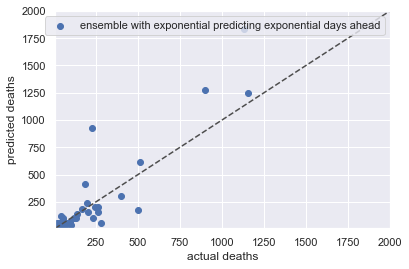

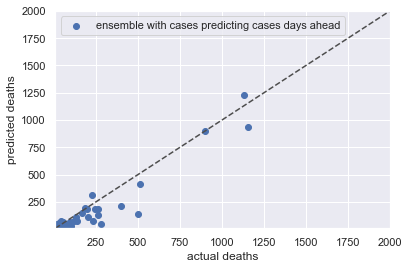

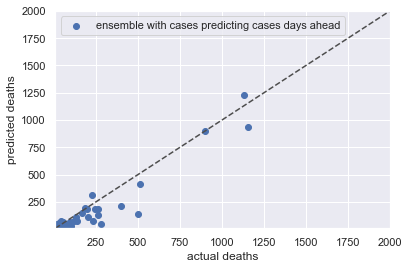

In [689]:
# Make non-log plots zoomed in for the counties that have a fewer number of deaths# We set bounds 
bounds = [10,2000]
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > 5]]
    plt.scatter(outcome[outcome > 5],preds,label=method_name_to_pretty_name(key))

    plt.xlabel('actual '+outcome_type)
    plt.ylabel('predicted '+outcome_type)
    plt.xlim(bounds)
    plt.ylim(bounds)
    plt.legend()

    plt.plot(bounds, bounds, ls="--", c=".3")
    plt.show()

### Graph Visualizations

In [555]:
# Here we visualize predictions on a per county level.
# The blue lines are the true number of deaths, and the dots are our predictions for each model for those days.

In [556]:
def plot_log(row):
    """
    Plots model predictions vs actual
    row: dataframe row
    window: autoregressive window size
    """
    gold_key = outcome_type
    for i,val in enumerate(row[gold_key]):
        if val > 0:
            start_point = i
            break
#     plt.plot(row[gold_key][start_point:], label=gold_key) 
    if len(row[gold_key][start_point:]) < 3:
        return
    values = [np.log(v+1) for v in list(row[outcome_type])[start_point:]]

    sns.lineplot(list(range(len(values))),values, label=outcome_type)

    
        
    
    


    plt.title(row['CountyName']+' in '+row['StateNameAbbreviation'])
    plt.ylabel(outcome_type)
    plt.xlabel('Days since first death')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.figure(dpi=500)    
    plt.show()

    

In [557]:
def plot_ratio(row):
    """
    Plots model predictions vs actual
    row: dataframe row
    window: autoregressive window size
    """
    gold_key = outcome_type
    for i,val in enumerate(row[gold_key]):
        if val > 0:
            start_point = i
            break
#     plt.plot(row[gold_key][start_point:], label=gold_key) 
    if len(row[gold_key][start_point:]) < 3:
        return
    prev = 5
    ratios = []
    values = list(row[outcome_type])[start_point:]
    for i in range(len(values)):
        ratios.append((values[i]+5)/prev)
        prev = values[i]+5
    
    sns.lineplot(list(range(len(values))),ratios, label=outcome_type)

    
        
    
    


    plt.title(row['CountyName']+' in '+row['StateNameAbbreviation'])
    plt.ylabel(outcome_type)
    plt.xlabel('Days since first death')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.figure(dpi=500)    
    plt.show()

    

In [690]:
def plot_prediction(row):
    """
    Plots model predictions vs actual
    row: dataframe row
    window: autoregressive window size
    """
    gold_key = outcome_type
    for i,val in enumerate(row[gold_key]):
        if val > 0:
            start_point = i
            break
#     plt.plot(row[gold_key][start_point:], label=gold_key) 
    if len(row[gold_key][start_point:]) < 3:
        return
    sns.lineplot(list(range(len(row[gold_key][start_point:]))),row[gold_key][start_point:], label=gold_key)
    
    

    for key in method_keys:
        preds = row[key]

        sns.scatterplot(list(range(len(row[gold_key][start_point:])))[-len(preds):],preds,label=method_name_to_pretty_name(key))
        
#         plt.scatter(list(range(len(row[gold_key][start_point:])))[-len(preds):],preds,label=key)
    
#     plt.legend()
#     plt.show()
#     sns.legend()
    plt.title(row['CountyName']+' in '+row['StateNameAbbreviation'])
    plt.ylabel(outcome_type)
    plt.xlabel('Days since first death')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.figure(dpi=500)    
    plt.show()

    

In [691]:
# feature_vals = {
# 'PopulationDensityperSqMile2010' : 1.1525491065255939e-05,
# "MedicareEnrollment,AgedTot2017" : -2.119520577282583e-06,
# 'PopulationEstimate2018' : 2.8898343032154275e-07,
# '#ICU_beds' : -0.000647030727828718,
# 'MedianAge2010' : 0.05032666600339253,
# 'Smokers_Percentage' : -0.013410742818946319,
# 'DiabetesPercentage' : 0.04395318355581005,
# 'HeartDiseaseMortality' : 0.0015473771787186525,
# '#Hospitals': 0.019248102357644396,
# 'log(deaths)' : 0.8805209010821442,
# 'bias' : -1.871552103871495
# }

Kings in NY


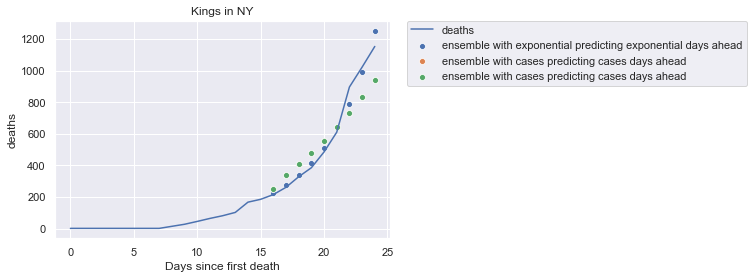

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 35369.2
Respiratory Mortality: 23.05
PopulationEstimate2018: 2582830.0
#ICU_beds: 318
MedianAge2010: 34.1
Smokers_Percentage: 13.840801998
DiabetesPercentage: 9.7
HeartDiseaseMortality: 195.8
#Hospitals: 12


Queens in NY


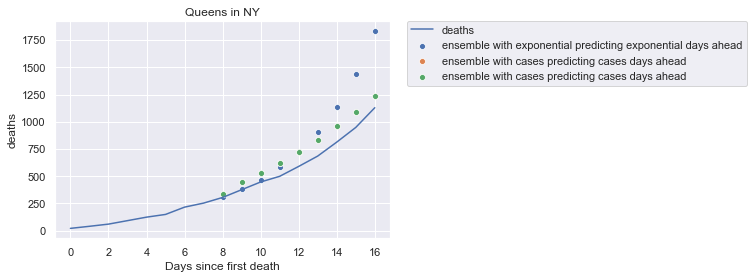

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 20553.6
Respiratory Mortality: 24.13
PopulationEstimate2018: 2278906.0
#ICU_beds: 129
MedianAge2010: 37.2
Smokers_Percentage: 12.42777748
DiabetesPercentage: 10.2
HeartDiseaseMortality: 180.0
#Hospitals: 6


Bronx in NY


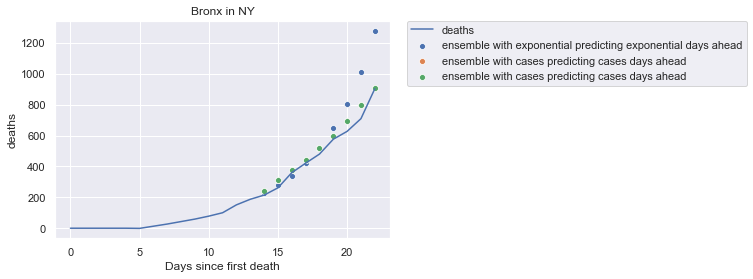

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 32903.3
Respiratory Mortality: 31.58
PopulationEstimate2018: 1432132.0
#ICU_beds: 270
MedianAge2010: 32.8
Smokers_Percentage: 15.921168722
DiabetesPercentage: 12.3
HeartDiseaseMortality: 201.3
#Hospitals: 6


New York in NY


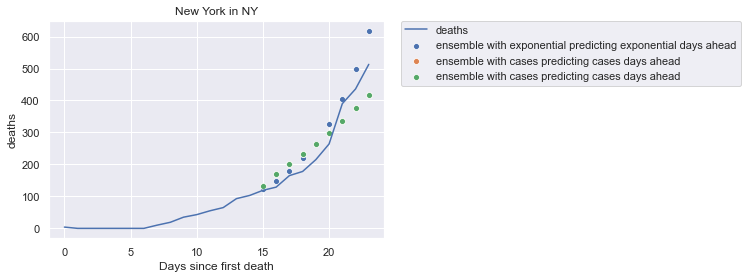

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 69468.4
Respiratory Mortality: 23.47
PopulationEstimate2018: 1628701.0
#ICU_beds: 761
MedianAge2010: 36.4
Smokers_Percentage: 12.41823421
DiabetesPercentage: 6.5
HeartDiseaseMortality: 143.5
#Hospitals: 12


Nassau in NY


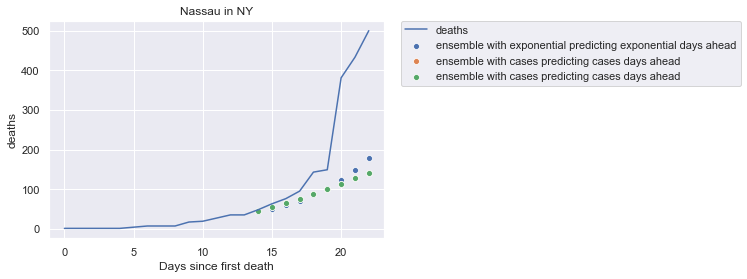

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 4704.8
Respiratory Mortality: 29.03
PopulationEstimate2018: 1358343.0
#ICU_beds: 461
MedianAge2010: 41.1
Smokers_Percentage: 11.225364644
DiabetesPercentage: 7.2
HeartDiseaseMortality: 188.2
#Hospitals: 10


Wayne in MI


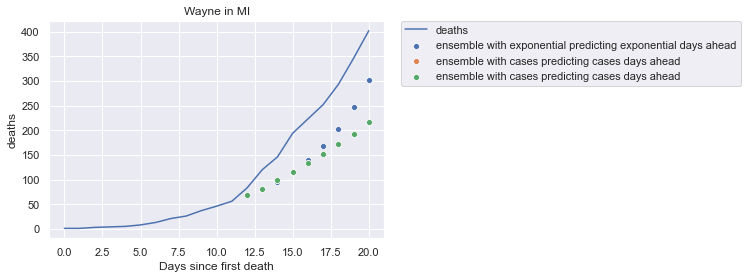

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2974.4
Respiratory Mortality: 53.48
PopulationEstimate2018: 1753893.0
#ICU_beds: 586
MedianAge2010: 37.3
Smokers_Percentage: 21.055529729
DiabetesPercentage: 10.3
HeartDiseaseMortality: 259.2
#Hospitals: 14


Westchester in NY


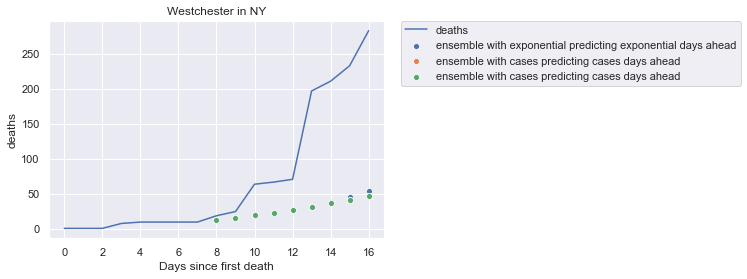

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2204.7
Respiratory Mortality: 31.82
PopulationEstimate2018: 967612.0
#ICU_beds: 179
MedianAge2010: 40.0
Smokers_Percentage: 11.37154602
DiabetesPercentage: 6.4
HeartDiseaseMortality: 146.8
#Hospitals: 9


Suffolk in NY


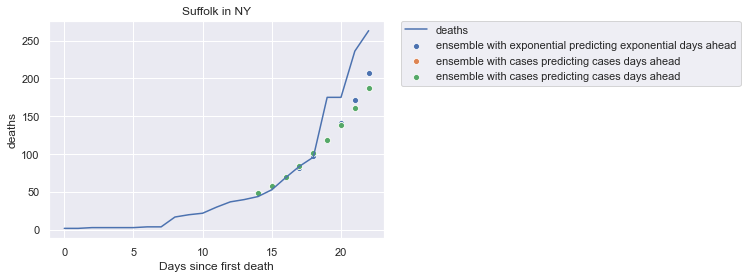

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1637.4
Respiratory Mortality: 38.59
PopulationEstimate2018: 1481093.0
#ICU_beds: 281
MedianAge2010: 39.8
Smokers_Percentage: 12.625481467
DiabetesPercentage: 6.8
HeartDiseaseMortality: 181.8
#Hospitals: 10


Bergen in NJ


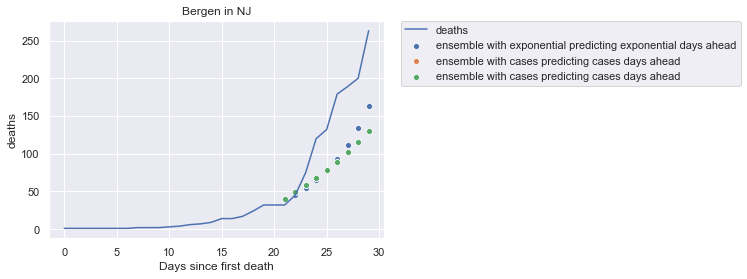

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 3884.5
Respiratory Mortality: 29.49
PopulationEstimate2018: 936692.0
#ICU_beds: 147
MedianAge2010: 41.1
Smokers_Percentage: 11.410986988
DiabetesPercentage: 6.8
HeartDiseaseMortality: 140.1
#Hospitals: 6


Cook in IL


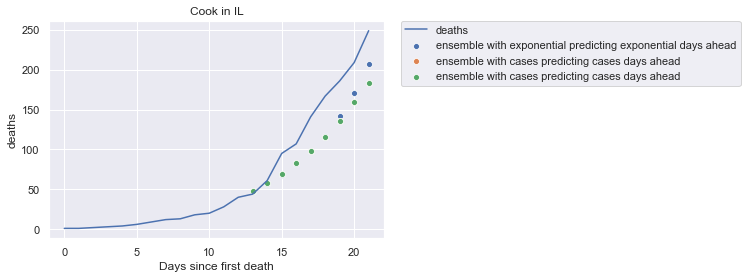

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 5495.1
Respiratory Mortality: 41.02
PopulationEstimate2018: 5180493.0
#ICU_beds: 1606
MedianAge2010: 35.3
Smokers_Percentage: 13.776183162
DiabetesPercentage: 9
HeartDiseaseMortality: 175.1
#Hospitals: 46


Essex in NJ


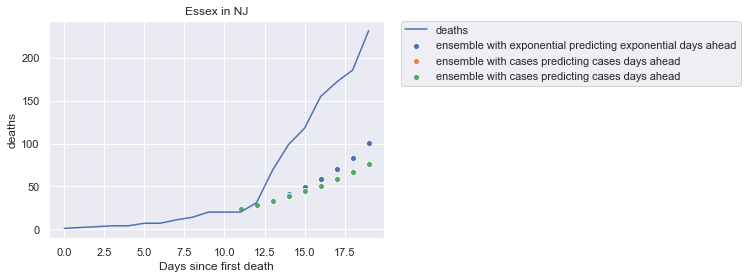

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 6211.5
Respiratory Mortality: 33.96
PopulationEstimate2018: 799767.0
#ICU_beds: 267
MedianAge2010: 36.4
Smokers_Percentage: 14.235389268
DiabetesPercentage: 9.9
HeartDiseaseMortality: 169.8
#Hospitals: 7


King in WA


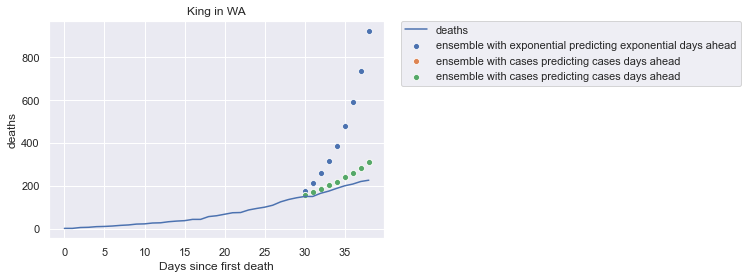

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 912.9
Respiratory Mortality: 37.33
PopulationEstimate2018: 2233163.0
#ICU_beds: 450
MedianAge2010: 37.1
Smokers_Percentage: 8.8150454593
DiabetesPercentage: 7.1
HeartDiseaseMortality: 118.9
#Hospitals: 17


Oakland in MI


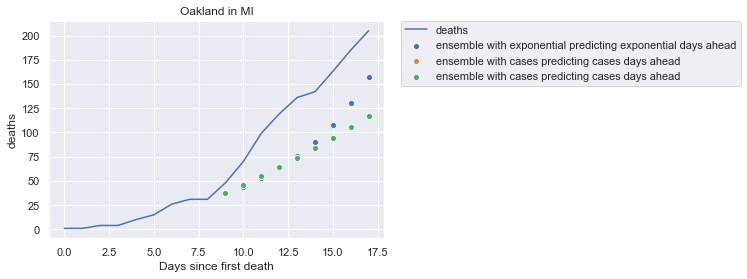

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1385.8
Respiratory Mortality: 46.33
PopulationEstimate2018: 1259201.0
#ICU_beds: 409
MedianAge2010: 40.2
Smokers_Percentage: 12.308266081
DiabetesPercentage: 7.7
HeartDiseaseMortality: 181.4
#Hospitals: 12


Richmond in NY


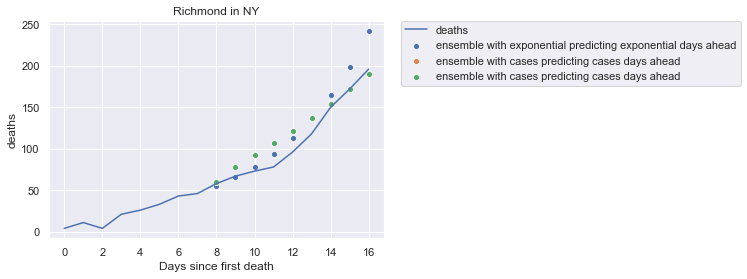

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 8030.3
Respiratory Mortality: 34.76
PopulationEstimate2018: 476179.0
#ICU_beds: 114
MedianAge2010: 38.4
Smokers_Percentage: 15.373417772
DiabetesPercentage: 9.6
HeartDiseaseMortality: 239.6
#Hospitals: 2


Orleans in LA


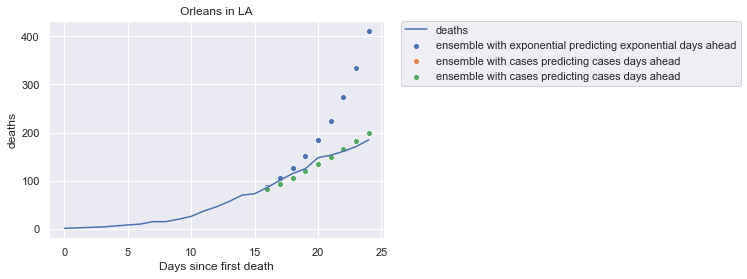

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2029.4
Respiratory Mortality: 39.42
PopulationEstimate2018: 391006.0
#ICU_beds: 111
MedianAge2010: 34.6
Smokers_Percentage: 22.609624129
DiabetesPercentage: 10.3
HeartDiseaseMortality: 189.7
#Hospitals: 5


Los Angeles in CA


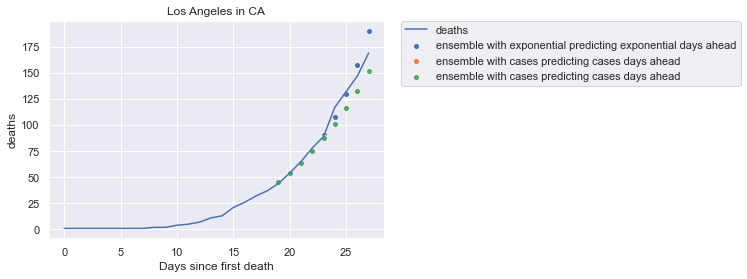

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2419.6
Respiratory Mortality: 34.94
PopulationEstimate2018: 10105518.0
#ICU_beds: 2126
MedianAge2010: 34.8
Smokers_Percentage: 10.847678109
DiabetesPercentage: 8.1
HeartDiseaseMortality: 150.8
#Hospitals: 76


Jefferson in LA


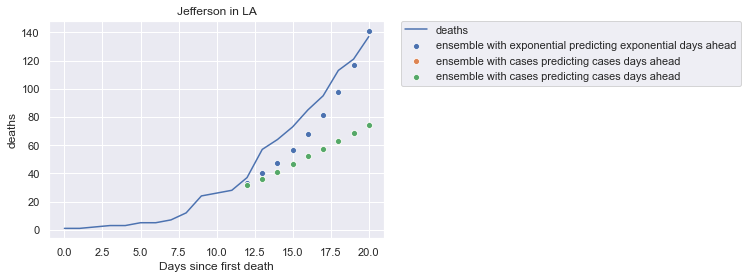

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1463.1
Respiratory Mortality: 53.68
PopulationEstimate2018: 434051.0
#ICU_beds: 215
MedianAge2010: 38.4
Smokers_Percentage: 18.743669593
DiabetesPercentage: 12.7
HeartDiseaseMortality: 178.7
#Hospitals: 5


Fairfield in CT


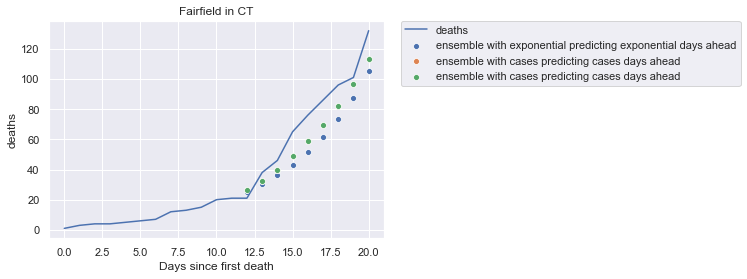

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1467.2
Respiratory Mortality: 34.15
PopulationEstimate2018: 943823.0
#ICU_beds: 173
MedianAge2010: 39.5
Smokers_Percentage: 10.157896011
DiabetesPercentage: 6.4
HeartDiseaseMortality: 137.1
#Hospitals: 6


Macomb in MI


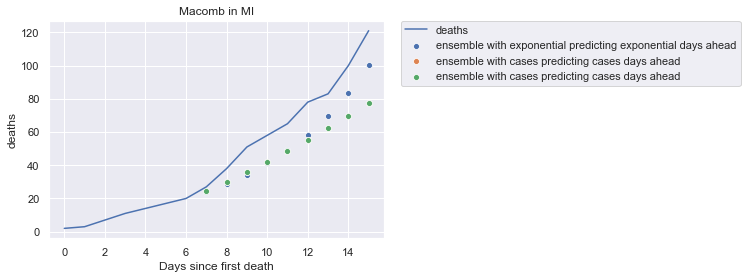

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1754.9
Respiratory Mortality: 53.07
PopulationEstimate2018: 874759.0
#ICU_beds: 122
MedianAge2010: 39.9
Smokers_Percentage: 18.558096157
DiabetesPercentage: 9.5
HeartDiseaseMortality: 196.6
#Hospitals: 4


Hudson in NJ


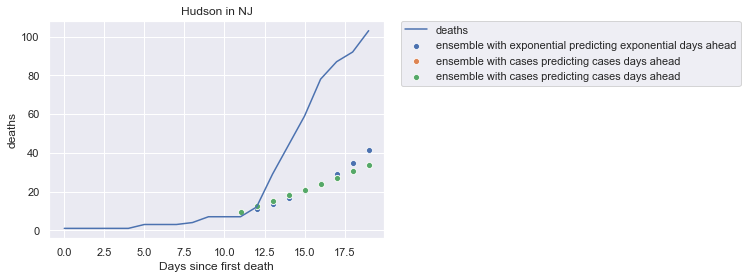

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 13731.4
Respiratory Mortality: 34.89
PopulationEstimate2018: 676061.0
#ICU_beds: 105
MedianAge2010: 34.2
Smokers_Percentage: 15.382038155
DiabetesPercentage: 8.2
HeartDiseaseMortality: 157.6
#Hospitals: 6


Middlesex in NJ


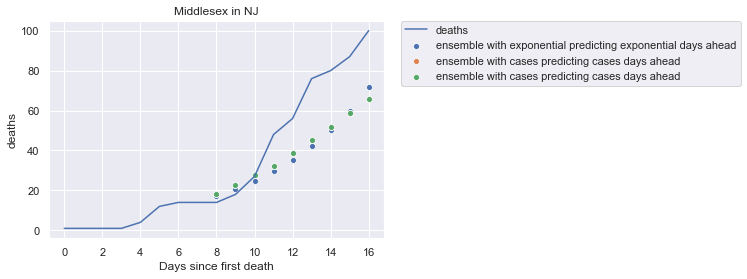

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2621.6
Respiratory Mortality: 35.07
PopulationEstimate2018: 829685.0
#ICU_beds: 185
MedianAge2010: 37.2
Smokers_Percentage: 10.970467888
DiabetesPercentage: 9.7
HeartDiseaseMortality: 154.3
#Hospitals: 5


Union in NJ


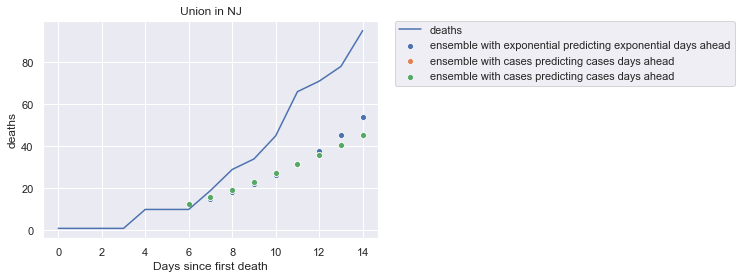

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 5216.1
Respiratory Mortality: 35.43
PopulationEstimate2018: 558067.0
#ICU_beds: 80
MedianAge2010: 38.0
Smokers_Percentage: 13.07573586
DiabetesPercentage: 7.5
HeartDiseaseMortality: 157.9
#Hospitals: 3


Rockland in NY


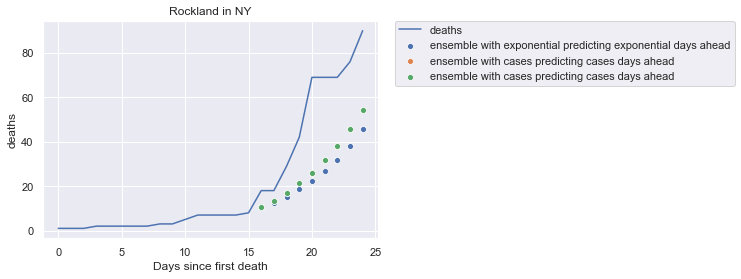

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1796.0
Respiratory Mortality: 33.58
PopulationEstimate2018: 325695.0
#ICU_beds: 39
MedianAge2010: 36.7
Smokers_Percentage: 12.165288495
DiabetesPercentage: 6.9
HeartDiseaseMortality: 150.9
#Hospitals: 3


Morris in NJ


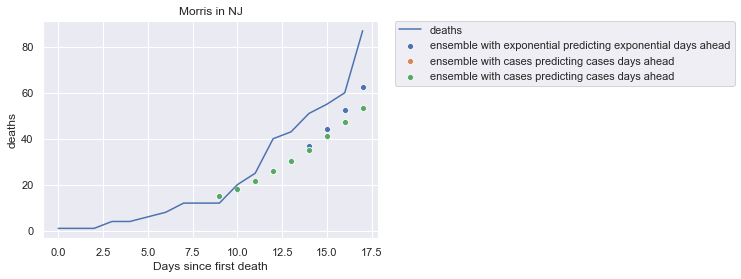

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1069.8
Respiratory Mortality: 34.49
PopulationEstimate2018: 494228.0
#ICU_beds: 91
MedianAge2010: 41.3
Smokers_Percentage: 12.111935176
DiabetesPercentage: 6.3
HeartDiseaseMortality: 143.5
#Hospitals: 3


Ocean in NJ


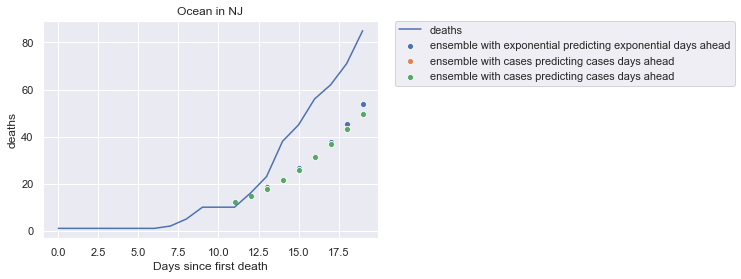

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 917.0
Respiratory Mortality: 43.02
PopulationEstimate2018: 601651.0
#ICU_beds: 106
MedianAge2010: 42.6
Smokers_Percentage: 14.443273724
DiabetesPercentage: 8.3
HeartDiseaseMortality: 202.7
#Hospitals: 4


Monmouth in NJ


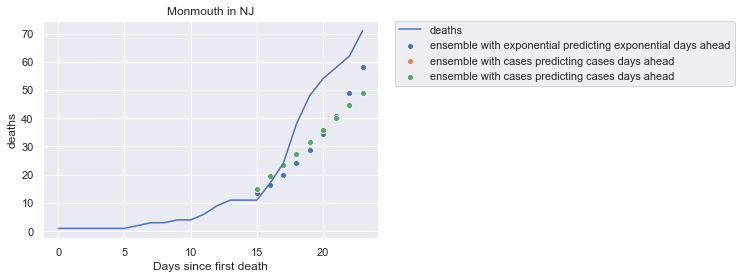

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1344.7
Respiratory Mortality: 44.08
PopulationEstimate2018: 621354.0
#ICU_beds: 152
MedianAge2010: 41.3
Smokers_Percentage: 13.360452416
DiabetesPercentage: 7.5
HeartDiseaseMortality: 159.1
#Hospitals: 5


Middlesex in MA


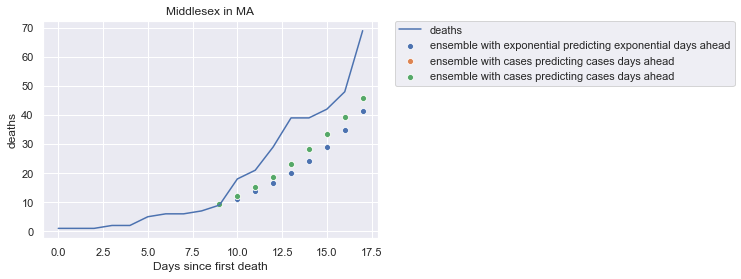

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1837.9
Respiratory Mortality: 36.99
PopulationEstimate2018: 1614714.0
#ICU_beds: 216
MedianAge2010: 38.5
Smokers_Percentage: 9.9544431395
DiabetesPercentage: 6.8
HeartDiseaseMortality: 121.8
#Hospitals: 11


Palm Beach in FL


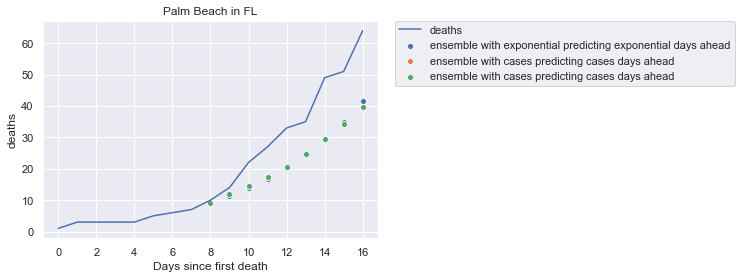

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 670.2
Respiratory Mortality: 32.77
PopulationEstimate2018: 1485941.0
#ICU_beds: 401
MedianAge2010: 43.5
Smokers_Percentage: 15.916105958
DiabetesPercentage: 7.7
HeartDiseaseMortality: 123.6
#Hospitals: 12


Passaic in NJ


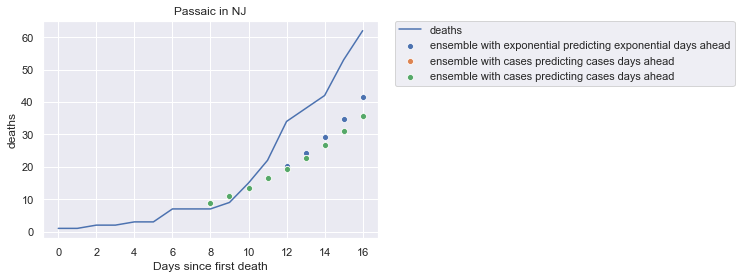

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2715.3
Respiratory Mortality: 40.21
PopulationEstimate2018: 503310.0
#ICU_beds: 97
MedianAge2010: 36.1
Smokers_Percentage: 13.782069143
DiabetesPercentage: 7.8
HeartDiseaseMortality: 167.4
#Hospitals: 2


New Haven in CT


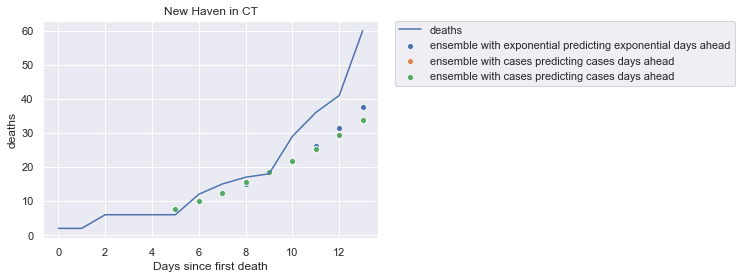

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1426.8
Respiratory Mortality: 45.49
PopulationEstimate2018: 857620.0
#ICU_beds: 186
MedianAge2010: 39.3
Smokers_Percentage: 12.843951967
DiabetesPercentage: 8.6
HeartDiseaseMortality: 148.4
#Hospitals: 8


Snohomish in WA


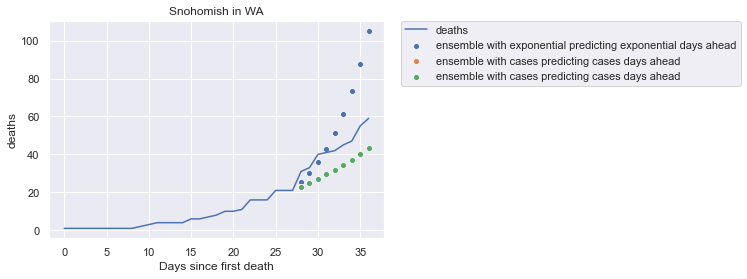

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 341.8
Respiratory Mortality: 50.18
PopulationEstimate2018: 814901.0
#ICU_beds: 72
MedianAge2010: 37.1
Smokers_Percentage: 12.962308599
DiabetesPercentage: 7.7
HeartDiseaseMortality: 131.9
#Hospitals: 4


Philadelphia in PA


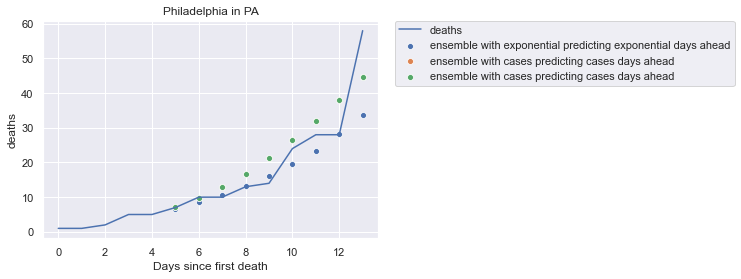

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 11379.5
Respiratory Mortality: 50.06
PopulationEstimate2018: 1584138.0
#ICU_beds: 528
MedianAge2010: 33.5
Smokers_Percentage: 20.614249405
DiabetesPercentage: 10.4
HeartDiseaseMortality: 213.7
#Hospitals: 15


Hampden in MA


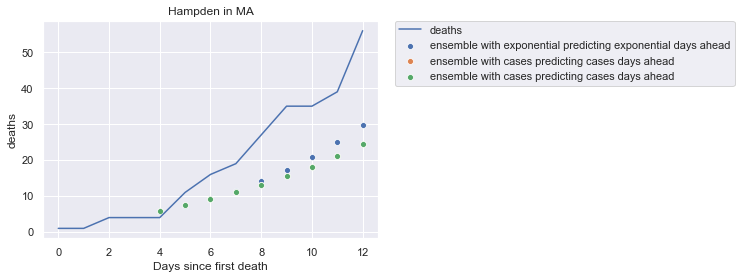

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 751.0
Respiratory Mortality: 49.07
PopulationEstimate2018: 470406.0
#ICU_beds: 119
MedianAge2010: 38.6
Smokers_Percentage: 15.440525252
DiabetesPercentage: 9.5
HeartDiseaseMortality: 150.8
#Hospitals: 5


Dougherty in GA


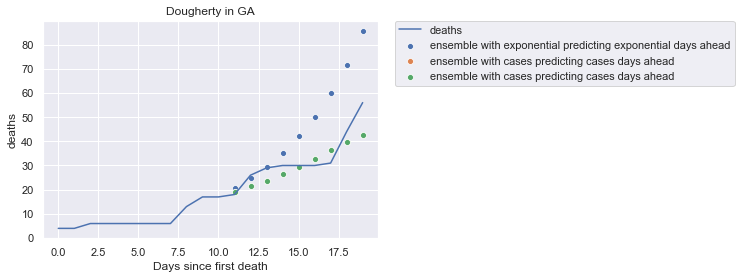

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 287.7
Respiratory Mortality: 66.83
PopulationEstimate2018: 91243.0
#ICU_beds: 50
MedianAge2010: 33.2
Smokers_Percentage: 21.607553194
DiabetesPercentage: 13.8
HeartDiseaseMortality: 178.8
#Hospitals: 1


Clark in NV


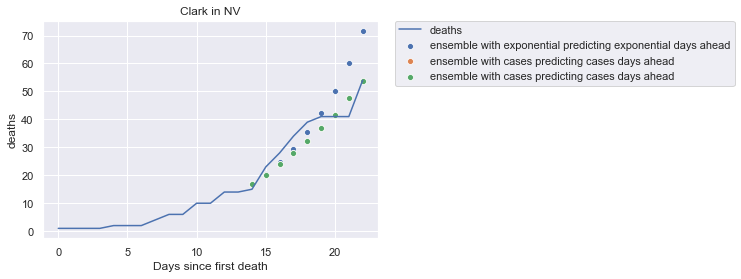

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 247.3
Respiratory Mortality: 63.75
PopulationEstimate2018: 2231647.0
#ICU_beds: 535
MedianAge2010: 35.5
Smokers_Percentage: 16.979704666
DiabetesPercentage: 10
HeartDiseaseMortality: 204.3
#Hospitals: 19


Broward in FL


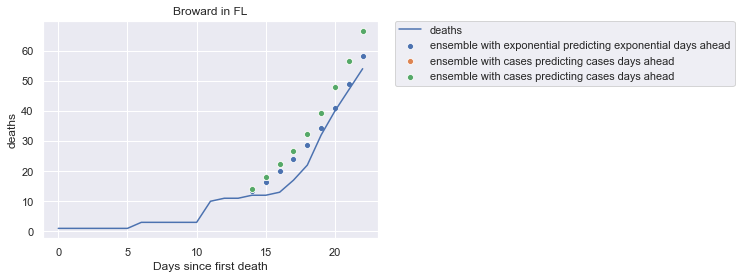

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1444.9
Respiratory Mortality: 39.77
PopulationEstimate2018: 1951260.0
#ICU_beds: 587
MedianAge2010: 39.7
Smokers_Percentage: 14.593792551
DiabetesPercentage: 8.1
HeartDiseaseMortality: 146.9
#Hospitals: 14


Orange in NY


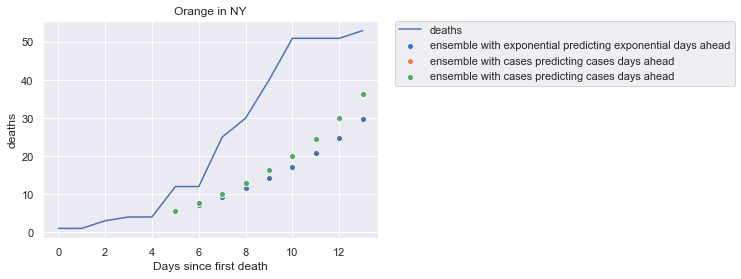

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 459.3
Respiratory Mortality: 52.02
PopulationEstimate2018: 381951.0
#ICU_beds: 76
MedianAge2010: 36.6
Smokers_Percentage: 15.142023205
DiabetesPercentage: 8.6
HeartDiseaseMortality: 180.8
#Hospitals: 4


Milwaukee in WI


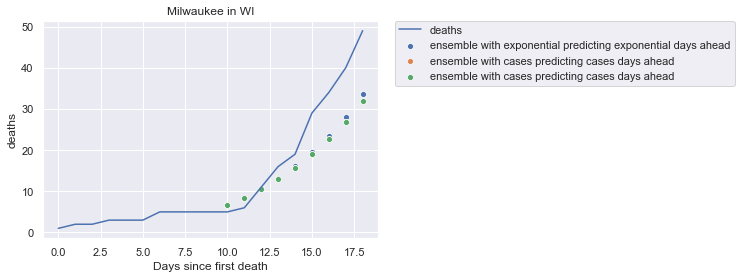

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 3926.0
Respiratory Mortality: 53.45
PopulationEstimate2018: 948201.0
#ICU_beds: 381
MedianAge2010: 33.6
Smokers_Percentage: 17.817309912
DiabetesPercentage: 10.1
HeartDiseaseMortality: 182.6
#Hospitals: 8


Hartford in CT


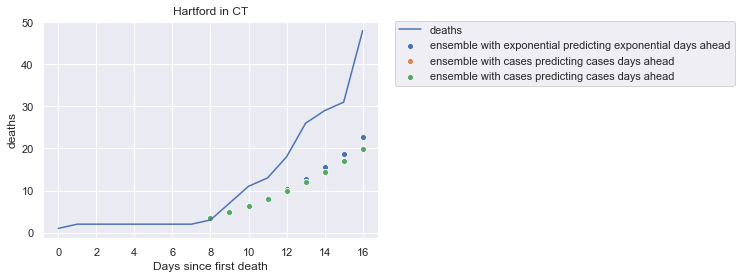

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1216.2
Respiratory Mortality: 44.55
PopulationEstimate2018: 892697.0
#ICU_beds: 216
MedianAge2010: 39.9
Smokers_Percentage: 11.356248016
DiabetesPercentage: 8.6
HeartDiseaseMortality: 149.3
#Hospitals: 7


Marion in IN


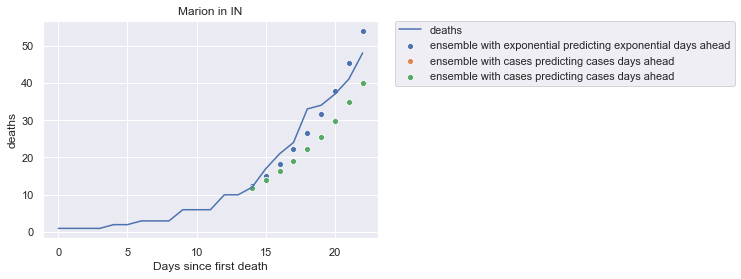

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2279.6
Respiratory Mortality: 78.21
PopulationEstimate2018: 954670.0
#ICU_beds: 526
MedianAge2010: 33.9
Smokers_Percentage: 19.241619979
DiabetesPercentage: 11.6
HeartDiseaseMortality: 183.2
#Hospitals: 9


Miami-Dade in FL


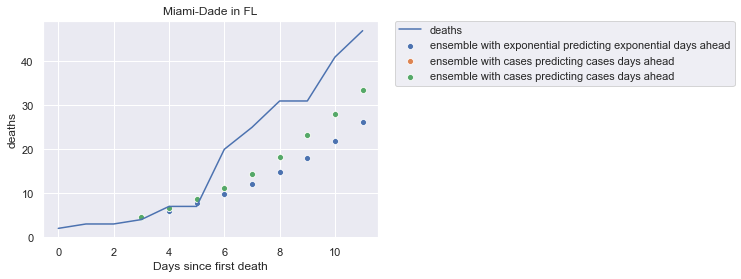

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1315.5
Respiratory Mortality: 33.65
PopulationEstimate2018: 2761581.0
#ICU_beds: 593
MedianAge2010: 38.2
Smokers_Percentage: 16.479410011
DiabetesPercentage: 6.7
HeartDiseaseMortality: 152.4
#Hospitals: 17


Santa Clara in CA


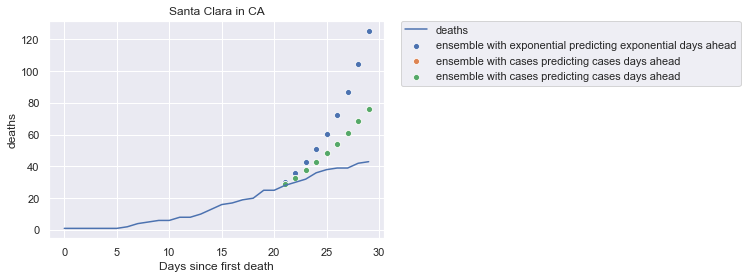

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1381.0
Respiratory Mortality: 29.68
PopulationEstimate2018: 1937570.0
#ICU_beds: 313
MedianAge2010: 36.2
Smokers_Percentage: 8.2690140125
DiabetesPercentage: 7.3
HeartDiseaseMortality: 104.2
#Hospitals: 9


Suffolk in MA


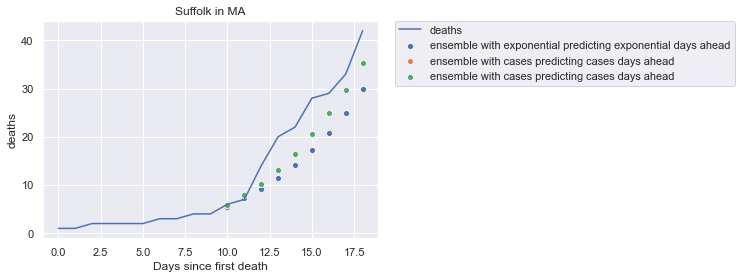

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 12415.7
Respiratory Mortality: 39.94
PopulationEstimate2018: 807252.0
#ICU_beds: 447
MedianAge2010: 31.5
Smokers_Percentage: 14.475410922
DiabetesPercentage: 9.1
HeartDiseaseMortality: 125.4
#Hospitals: 10


Somerset in NJ


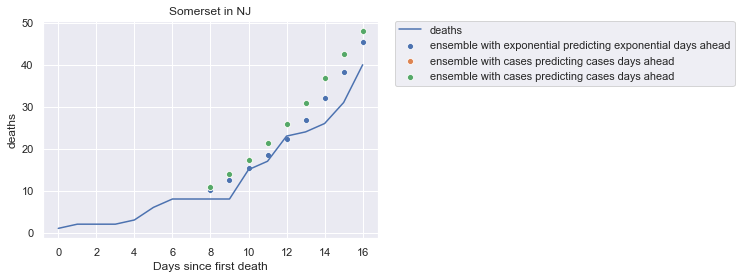

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1071.7
Respiratory Mortality: 37.00
PopulationEstimate2018: 331164.0
#ICU_beds: 28
MedianAge2010: 40.2
Smokers_Percentage: 10.843821151
DiabetesPercentage: 6.2
HeartDiseaseMortality: 136.2
#Hospitals: 1


Fulton in GA


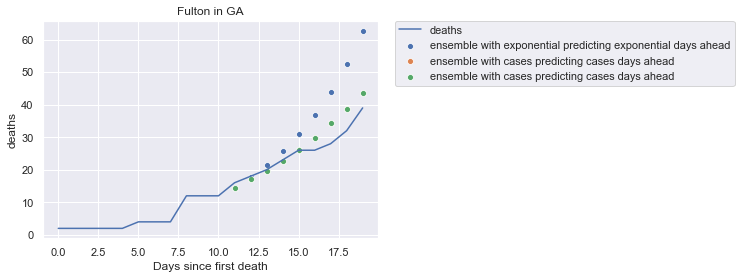

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1748.1
Respiratory Mortality: 40.61
PopulationEstimate2018: 1050114.0
#ICU_beds: 538
MedianAge2010: 34.2
Smokers_Percentage: 14.925509463
DiabetesPercentage: 8.3
HeartDiseaseMortality: 157.6
#Hospitals: 7


Erie in NY


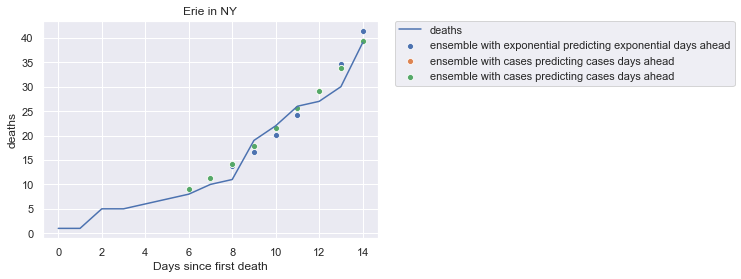

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 881.4
Respiratory Mortality: 48.21
PopulationEstimate2018: 919719.0
#ICU_beds: 262
MedianAge2010: 40.4
Smokers_Percentage: 17.253724261
DiabetesPercentage: 9.6
HeartDiseaseMortality: 180.9
#Hospitals: 6


Essex in MA


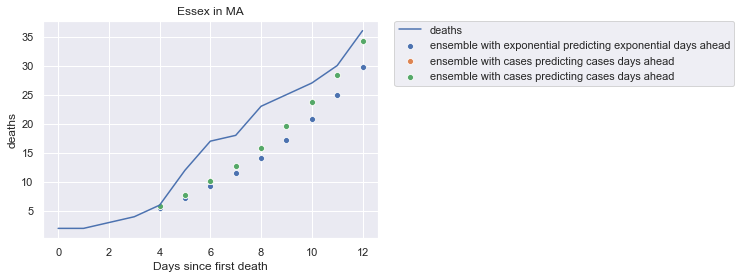

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1508.8
Respiratory Mortality: 44.01
PopulationEstimate2018: 790638.0
#ICU_beds: 98
MedianAge2010: 40.4
Smokers_Percentage: 11.74006476
DiabetesPercentage: 8.3
HeartDiseaseMortality: 135.7
#Hospitals: 5


Maricopa in AZ


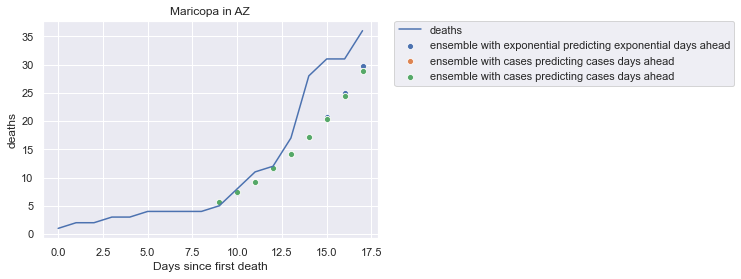

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 414.9
Respiratory Mortality: 51.21
PopulationEstimate2018: 4410824.0
#ICU_beds: 1004
MedianAge2010: 34.6
Smokers_Percentage: 13.686398251
DiabetesPercentage: 8.2
HeartDiseaseMortality: 130.3
#Hospitals: 34


Norfolk in MA


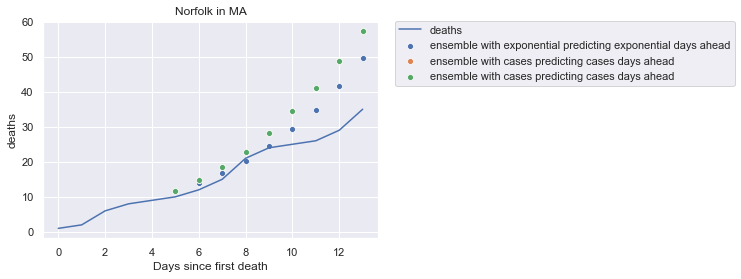

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1693.6
Respiratory Mortality: 39.61
PopulationEstimate2018: 705388.0
#ICU_beds: 59
MedianAge2010: 40.7
Smokers_Percentage: 12.238980283
DiabetesPercentage: 7.3
HeartDiseaseMortality: 130.5
#Hospitals: 4


St. John the Baptist in LA


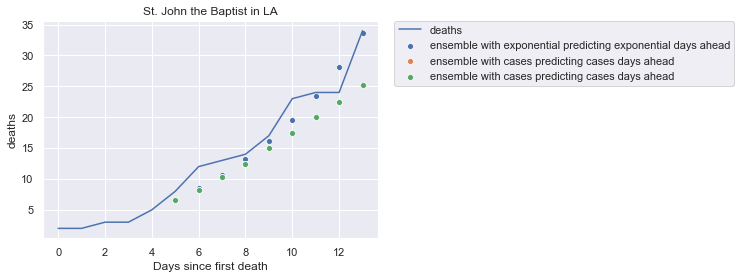

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 215.5
Respiratory Mortality: 47.73
PopulationEstimate2018: 43184.0
#ICU_beds: 0
MedianAge2010: 35.5
Smokers_Percentage: 20.516015542
DiabetesPercentage: 9
HeartDiseaseMortality: 229.3
#Hospitals: 0


Genesee in MI


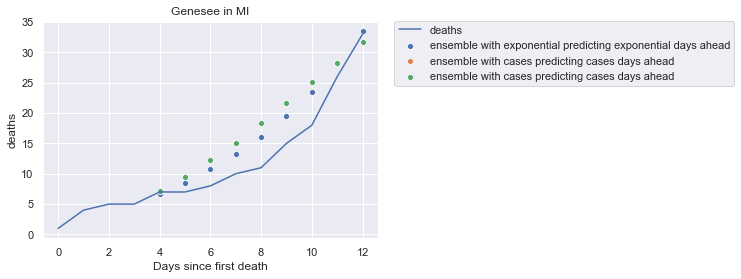

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 668.5
Respiratory Mortality: 66.89
PopulationEstimate2018: 406892.0
#ICU_beds: 151
MedianAge2010: 38.5
Smokers_Percentage: 18.986887756
DiabetesPercentage: 11.6
HeartDiseaseMortality: 227.3
#Hospitals: 3


San Diego in CA


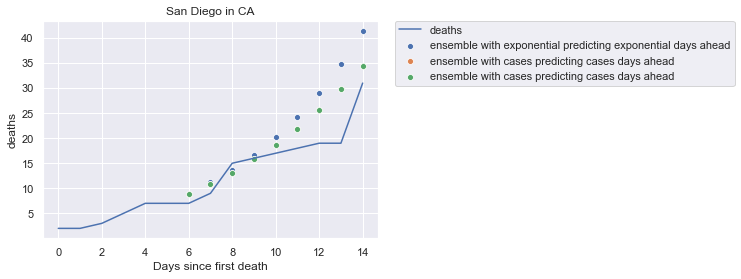

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 735.8
Respiratory Mortality: 38.91
PopulationEstimate2018: 3343364.0
#ICU_beds: 570
MedianAge2010: 34.6
Smokers_Percentage: 10.753175291
DiabetesPercentage: 6.9
HeartDiseaseMortality: 132.4
#Hospitals: 15


East Baton Rouge in LA


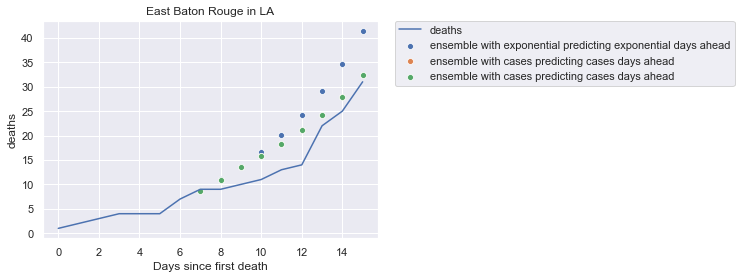

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 966.6
Respiratory Mortality: 49.50
PopulationEstimate2018: 440956.0
#ICU_beds: 124
MedianAge2010: 32.6
Smokers_Percentage: 18.269947005
DiabetesPercentage: 11.3
HeartDiseaseMortality: 216.4
#Hospitals: 7


Denver in CO


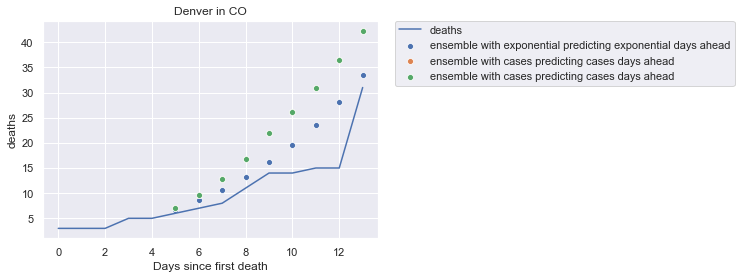

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 3922.6
Respiratory Mortality: 57.93
PopulationEstimate2018: 716492.0
#ICU_beds: 227
MedianAge2010: 33.7
Smokers_Percentage: 14.664503351
DiabetesPercentage: 5.7
HeartDiseaseMortality: 146.5
#Hospitals: 6


Will in IL


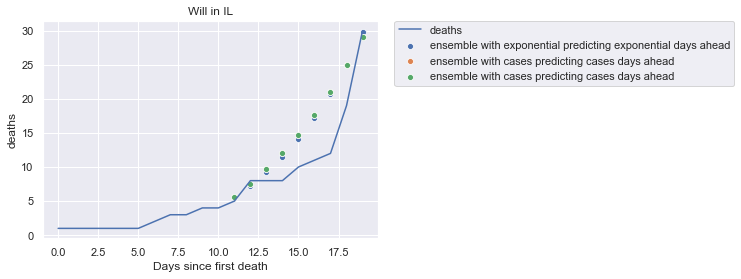

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 809.6
Respiratory Mortality: 45.10
PopulationEstimate2018: 692310.0
#ICU_beds: 92
MedianAge2010: 35.4
Smokers_Percentage: 13.070465481
DiabetesPercentage: 8.9
HeartDiseaseMortality: 167.0
#Hospitals: 3


Montgomery in PA


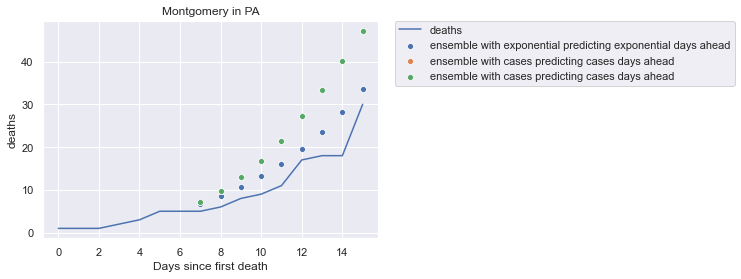

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1655.9
Respiratory Mortality: 43.32
PopulationEstimate2018: 828604.0
#ICU_beds: 215
MedianAge2010: 40.6
Smokers_Percentage: 13.194677885
DiabetesPercentage: 7
HeartDiseaseMortality: 142.7
#Hospitals: 11


Cobb in GA


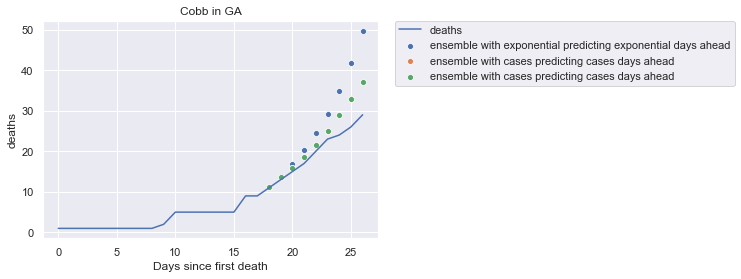

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2026.5
Respiratory Mortality: 46.80
PopulationEstimate2018: 756865.0
#ICU_beds: 119
MedianAge2010: 35.4
Smokers_Percentage: 12.634027364
DiabetesPercentage: 8.4
HeartDiseaseMortality: 139.7
#Hospitals: 2


El Paso in CO


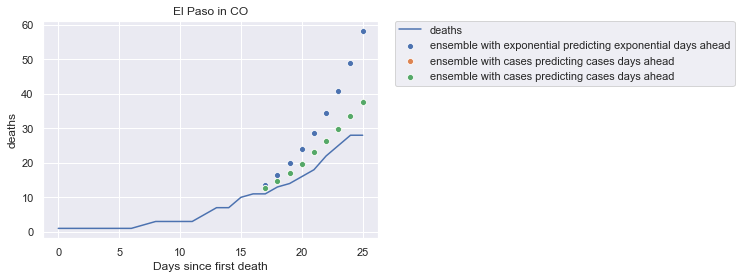

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 292.6
Respiratory Mortality: 58.05
PopulationEstimate2018: 713856.0
#ICU_beds: 95
MedianAge2010: 34.1
Smokers_Percentage: 14.264909913
DiabetesPercentage: 6.5
HeartDiseaseMortality: 135.6
#Hospitals: 3


Riverside in CA


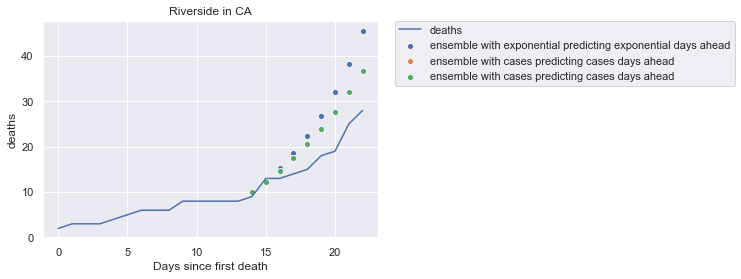

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 303.8
Respiratory Mortality: 50.72
PopulationEstimate2018: 2450758.0
#ICU_beds: 351
MedianAge2010: 33.7
Smokers_Percentage: 12.499944322
DiabetesPercentage: 8.7
HeartDiseaseMortality: 167.8
#Hospitals: 16


Henrico in VA


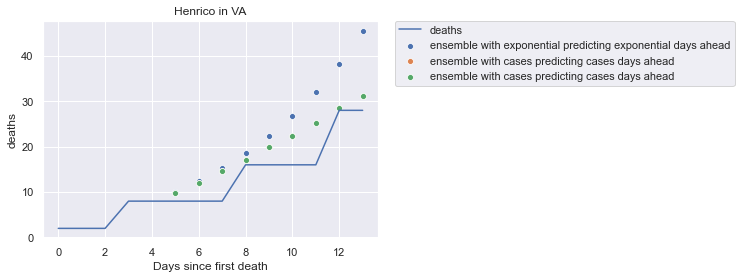

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1313.4
Respiratory Mortality: 51.50
PopulationEstimate2018: 329261.0
#ICU_beds: 53
MedianAge2010: 37.5
Smokers_Percentage: 15.165087834
DiabetesPercentage: 8.5
HeartDiseaseMortality: 155.3
#Hospitals: 1


Jefferson in KY


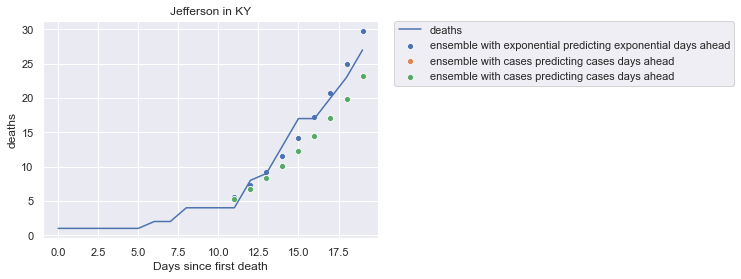

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1948.1
Respiratory Mortality: 66.47
PopulationEstimate2018: 770517.0
#ICU_beds: 366
MedianAge2010: 37.9
Smokers_Percentage: 19.826956296
DiabetesPercentage: 10.9
HeartDiseaseMortality: 168.4
#Hospitals: 4


Weld in CO


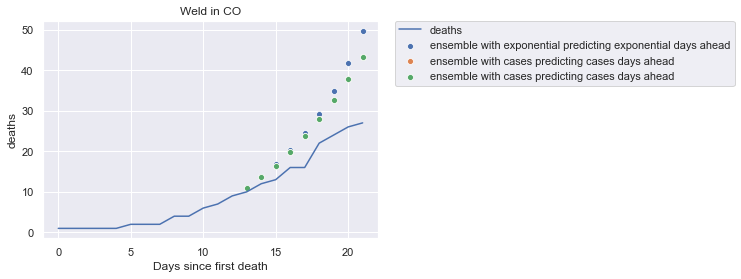

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 63.4
Respiratory Mortality: 57.93
PopulationEstimate2018: 314305.0
#ICU_beds: 26
MedianAge2010: 33.1
Smokers_Percentage: 13.748363782
DiabetesPercentage: 6.9
HeartDiseaseMortality: 132.8
#Hospitals: 1


Caddo in LA


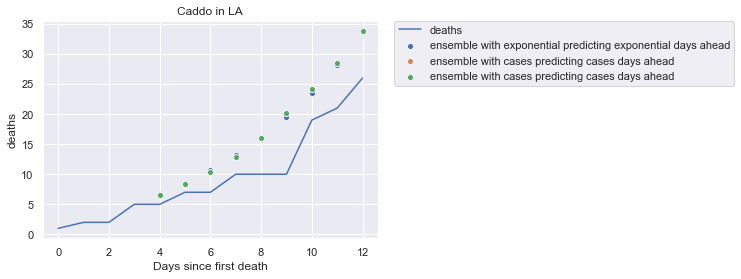

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 290.2
Respiratory Mortality: 69.70
PopulationEstimate2018: 242922.0
#ICU_beds: 107
MedianAge2010: 36.4
Smokers_Percentage: 21.923980452
DiabetesPercentage: 11.5
HeartDiseaseMortality: 163.7
#Hospitals: 5


Prince George's in MD


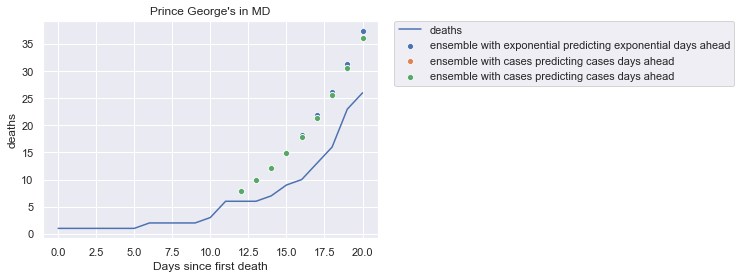

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1788.8
Respiratory Mortality: 26.31
PopulationEstimate2018: 909308.0
#ICU_beds: 89
MedianAge2010: 34.9
Smokers_Percentage: 11.97912293
DiabetesPercentage: 12.1
HeartDiseaseMortality: 172.2
#Hospitals: 5


DuPage in IL


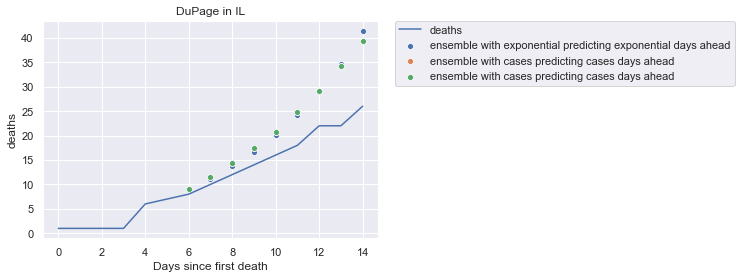

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2799.8
Respiratory Mortality: 40.66
PopulationEstimate2018: 928589.0
#ICU_beds: 257
MedianAge2010: 38.2
Smokers_Percentage: 12.257496254
DiabetesPercentage: 7.7
HeartDiseaseMortality: 127.9
#Hospitals: 6


Monroe in NY


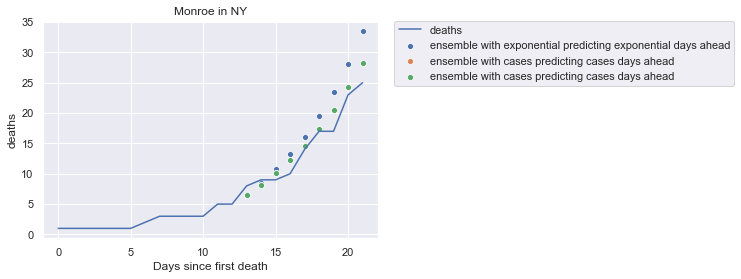

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1132.6
Respiratory Mortality: 37.67
PopulationEstimate2018: 742474.0
#ICU_beds: 191
MedianAge2010: 38.5
Smokers_Percentage: 15.151442269
DiabetesPercentage: 8.4
HeartDiseaseMortality: 149.3
#Hospitals: 5


Plymouth in MA


ValueError: arrays must all be same length

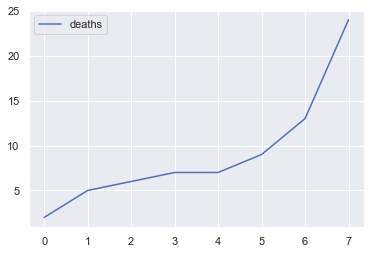

In [692]:
df = df.sort_values(by='max_deaths',ascending=False)
for i in range(len(df)):
    row = df.iloc[i]
    # If number of deaths greater than 10
    if max(row['deaths']) > 10:
        print(row['CountyName']+' in '+row['StateNameAbbreviation'])
        plot_prediction(row)
#         plot_log(row)

        for v in very_important_vars:
            print(v+ ': '+str(row[v])) #+';\t contrib: '+ str(feature_vals[v]*float(row[v])))
        print('\n')